L'objectif de ce TP est d'effectuer un transfert learning sur le jeu de donnée précédent

Commençons par récupérer/parser le jeu de donnée tel qu'au tp précédent :

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, BatchNormalization
from tensorflow.keras.backend import resize_images
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Construisons le modele

J'ai fais le choix de partir de Mobilenet (entrainé sur imagenet) pour ce TP. Ce n'est pas le plus performant,
mais c'est un des plus rapide, car comme son nom l'indique il a été conçu pour tourner sur téléphone
- Mobilenet (et la plupart des modeles disponible dans keras) ont des contraintes sur le format de l'entrée
    - il n'accepte que des images de taille minimum 32x32 et en RGB (3 channels)
    - il nous faut donc transformer le jeu de donnée "comme on peut", pour atteindre cette résolution

- Pour transformer une image en niveau de gris en rgb, nous pouvons tout simplement dupliquer son channel existant.
- On obtient donc une image en 3 channel, 3x le même (visuellement elle donnera l'air d'etre toujours en noir et blanc)
- Ce n'est pas grave car la plupart des réseaux de neurones travaille sur des images en niveau de gris en interne, et font la conversion inverse

In [2]:
x_train_3chan = np.repeat(x_train, 3, -1)
x_test_3chan = np.repeat(x_test, 3, -1)


- il nous faut maintenant augmenter sa taille
- nous pourrions le faire avec opencv et resize, mais keras possède également sa méthode resize.
- une astuce consiste à upsizer en un multiple de la taille originale par une constante plutôt que de convertir directement en 32*32. Comme cela, nous évitons une interpolation de pixels inexacts.

In [3]:
input_image = Input(shape=(28, 28, 3))
resized_image = Lambda(lambda image: resize_images(
    x=image, height_factor=2, width_factor=2, data_format='channels_last'))(input_image)


- chargeons le modele pré-entrainé
- include_top=false permet de récupérer uniquement la partie convolution

In [4]:
base_model = MobileNet(
    weights='imagenet', include_top=False, input_tensor=resized_image)
base_model.trainable = False
x = base_model.output


2021-12-16 15:42:36.951701: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-16 15:42:36.952890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-16 15:42:36.957753: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Sauvegarde des prédis pour éviter de surcharger le model.fit

In [5]:
%%time

res_train = base_model.predict(x_train_3chan)
res_test = base_model.predict(x_test_3chan)

print(res_train.shape, res_test.shape)


2021-12-16 15:42:50.130027: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-16 15:42:50.134136: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2294685000 Hz


(60000, 1, 1, 1024) (10000, 1, 1, 1024)
CPU times: user 15min 8s, sys: 8min 49s, total: 23min 58s
Wall time: 6min 9s


- maintenant, construisez la partie classification qui sera entrainée lors du TL, ajouter l'optimizer et la loss, ... Vous devez savoir faire maintenant !
- verifiez avec base_model.summary() que votre modele ressemble bien à ce que vous attendez

In [6]:
keras.backend.clear_session()
# TODO remplir cette cellule

res_input = Input(shape=(1, 1, 1024))

flatten = Flatten()(res_input)
batch = BatchNormalization()(flatten)
dropout = Dropout(.2)(batch)

dense_64 = Dense(86, activation='relu')(dropout)
dense_32 = Dense(64, activation='relu')(dense_64)
dense_10 = Dense(32, activation='relu')(dense_32)
outputs = Dense(num_classes, activation='softmax')(dense_10)

model = Model(inputs=res_input, outputs=outputs, name='Mnist_TL')

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizer.Adam(learning_rate=.001), metrics=['accuracy'])


model.summary()


Model: "Mnist_TL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1, 1024)]      0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 86)                88150     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5568      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                208

## Transfert Learning

In [7]:
%%time
# TODO : Entrainer votre modèle

epochs = 10
batch_size = 256

hist = model.fit(res_train, y_train, epochs=epochs,
                    batch_size=batch_size, validation_data=(res_test, y_test))


Epoch 1/10
600/600 [==============================] - 30s 43ms/step - loss: 1.6702 - accuracy: 0.4138 - val_loss: 1.2889 - val_accuracy: 0.5542
Epoch 2/10
600/600 [==============================] - 26s 43ms/step - loss: 1.4086 - accuracy: 0.4979 - val_loss: 1.2591 - val_accuracy: 0.5657
Epoch 3/10
600/600 [==============================] - 29s 48ms/step - loss: 1.3831 - accuracy: 0.5052 - val_loss: 1.2356 - val_accuracy: 0.5732
Epoch 4/10
600/600 [==============================] - 28s 47ms/step - loss: 1.3735 - accuracy: 0.5110 - val_loss: 1.2164 - val_accuracy: 0.5781
Epoch 5/10
600/600 [==============================] - 37s 61ms/step - loss: 1.3684 - accuracy: 0.5105 - val_loss: 1.2284 - val_accuracy: 0.5737
Epoch 6/10
600/600 [==============================] - 28s 47ms/step - loss: 1.3496 - accuracy: 0.5155 - val_loss: 1.2133 - val_accuracy: 0.5821
Epoch 7/10
600/600 [==============================] - 29s 48ms/step - loss: 1.3496 - accuracy: 0.5151 - val_loss: 1.2087 - val_accuracy:

### Evaluation

313/313 [==============================] - 10s 28ms/step - loss: 1.1926 - accuracy: 0.5826


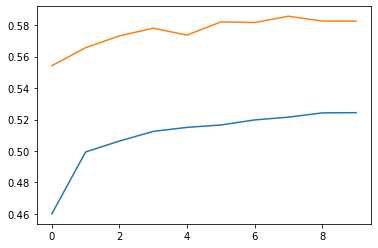

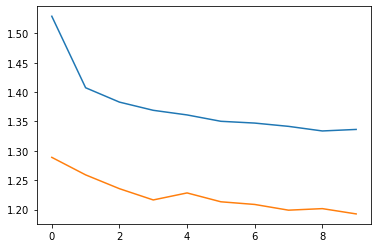

In [12]:
# TODO : Evaluez votre modele
 
test_loss, test_accu = model.evaluate(x=res_test, y=y_test)

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()


Et maintenant, optimisez votre solution :
- Faire du Finetuning à partir du reseau que vous venez d'entrainer
- améliorer votre architecture.
- ajouter de la data augmentation